In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def append_ext(fn):
    return fn + ".png"

# Load the dataset
train_dataframe = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv", dtype=str)
train_dataframe['id_code'] = train_dataframe['id_code'].apply(append_ext)
train_dataframe.head()


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


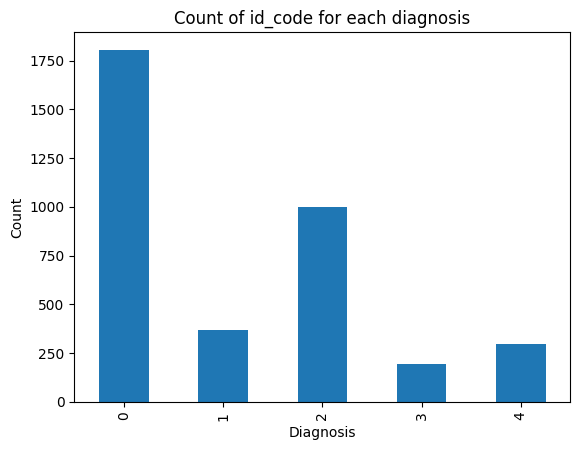

In [4]:
diagnosis_counts = train_dataframe.groupby('diagnosis')['id_code'].count()

# Plot the counts
diagnosis_counts.plot(kind='bar')

# Add labels and title to the plot
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Count of id_code for each diagnosis')

# Display the plot
plt.show()

In [5]:


# Split the dataset into training, validation, and test sets
X = train_dataframe['id_code']
y = train_dataframe['diagnosis']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)
train_df = pd.DataFrame({'id_code': X_train, 'diagnosis': y_train}).reset_index(drop=True)
valid_df = pd.DataFrame({'id_code': X_valid, 'diagnosis': y_valid}).reset_index(drop=True)
test_df = pd.DataFrame({'id_code': X_test, 'diagnosis': y_test}).reset_index(drop=True)


In [6]:

# Define a function to append file extensions to file names

# Create data generators for image data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0,
                                                               rotation_range=10,
                                                               zoom_range=0.30,
                                                               shear_range=0.30,
                                                               fill_mode="nearest")

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0)

In [7]:
images_directory = "/kaggle/input/aptos2019-blindness-detection/train_images"
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=images_directory,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                    directory=images_directory,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=images_directory,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  batch_size=batch_size)

Found 2965 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.
Found 330 validated image filenames belonging to 5 classes.


In [8]:
import tensorflow as tf
import tensorflow_hub as hub

In [10]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [11]:
# Define the teacher models
def create_teacher_model(model_name, num_classes=5):
    pre_trained_model = keras.applications.__dict__[model_name](weights='imagenet', include_top=False)
    
    x = keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    teacher_model = keras.models.Model(inputs=pre_trained_model.input, outputs=x)
    
    return teacher_model

teacher_models = {
    'VGG16': create_teacher_model('VGG16', num_classes=5),
    'VGG19': create_teacher_model('VGG19', num_classes=5),
    'Xception': create_teacher_model('Xception', num_classes=5),
    'InceptionV3': create_teacher_model('InceptionV3', num_classes=5),
    'ResNet50': create_teacher_model('ResNet50', num_classes=5)
}

import tensorflow as tf
import tensorflow_hub as hub
from efficientnet.keras import EfficientNetB3



# Create the NASNetLarge model with the modified input shape
def create_student_model(num_classes=5):
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(331, 331, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the base model layers for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Compile and train the model as before


student_model = create_student_model(num_classes=5)

44107200/44107200 [==============================] - 0s 0us/step


In [12]:
# Define the Distiller class
class Distiller(keras.Model):
    def __init__(self, student, teachers):
        super().__init__()
        self.teachers = teachers
        self.student = student

    def call(self, inputs, training=False):
        # Forward pass through the student model
        student_logits = self.student(inputs, training=training)
        # Forward pass through each teacher model
        teacher_logits = [teacher(inputs, training=training) for teacher in self.teachers]
        return student_logits, teacher_logits


    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = [teacher(x, training=False) for teacher in self.teachers]

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = 0

            for i, teacher_pred in enumerate(teacher_predictions):
                distillation_loss += self.distillation_loss_fn(
                    tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1)
                )

            distillation_loss /= len(self.teachers)
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
# Create instances of teacher and student models
teachers = [teacher_models[name] for name in ['VGG16', 'VGG19', 'Xception', 'InceptionV3', 'ResNet50']]
student = create_student_model()

# Create a distiller
distiller = Distiller(student=student, teachers=teachers)

# Compile the distiller
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=20
)

# Create an instance of the distiller model

In [ ]:
# Implement early stopping and checkpoint
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_student_model.h5', save_best_only=True)

student_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = student_model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    epochs=3,
    callbacks=[early_stopping, model_checkpoint]  # Add the callbacks
)

Epoch 1/3


2024-01-22 04:59:46.076093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  4/186 [..............................] - ETA: 5:02 - loss: 0.7501 - accuracy: 0.7188

In [ ]:
# student_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# history = student_model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(valid_generator),
#     epochs=8
# )

In [ ]:
teachers = [teacher_models[name] for name in ['VGG16', 'VGG19', 'Xception', 'InceptionV3', 'ResNet50']]
student = create_student_model()

# Create a distiller
distiller = Distiller(student=student, teachers=teachers)

# Compile and train the distiller model
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=20
)

distiller_history = distiller.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    epochs=8
)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Evaluate the student model
student_predictions = student_model.predict(test_generator)
student_predicted_labels = np.argmax(student_predictions, axis=1)

# Get true labels from the test data generator
student_true_labels = test_generator.classes

# Calculate and print a classification report for the student model
print('Student Model Classification Report:\n', classification_report(student_true_labels, student_predicted_labels, target_names=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']))

# Calculate and print other metrics for the student model
student_accuracy = accuracy_score(student_true_labels, student_predicted_labels)
student_precision = precision_score(student_true_labels, student_predicted_labels, average='weighted', zero_division=1)
student_recall = recall_score(student_true_labels, student_predicted_labels, average='weighted')
student_f1 = f1_score(student_true_labels, student_predicted_labels, average='weighted', zero_division=1)

# Calculate micro-averaged sensitivity and specificity for the student model
student_conf_matrix = confusion_matrix(student_true_labels, student_predicted_labels)
student_sensitivity_micro = recall_score(student_true_labels, student_predicted_labels, average='micro')
student_specificity_micro = (np.sum(student_conf_matrix) - np.diag(student_conf_matrix).sum()) / (np.sum(student_conf_matrix) - np.diag(student_conf_matrix).sum())

# Macro-averaged sensitivity and specificity for the student model
student_sensitivity_macro = recall_score(student_true_labels, student_predicted_labels, average='macro')
student_specificity_macro = specificity_macro = np.mean([(np.sum(student_conf_matrix) - np.sum(student_conf_matrix[i]) - np.sum(student_conf_matrix[:, i]) + student_conf_matrix[i][i]) / (np.sum(student_conf_matrix) - np.sum(student_conf_matrix[i]) - np.sum(student_conf_matrix[:, i]) + 1) for i in range(len(student_conf_matrix))])

# Print metrics for the student model
print('Student Model Accuracy:', student_accuracy)
print('Student Model Precision:', student_precision)
print('Student Model Recall:', student_recall)
print('Student Model F1 Score:', student_f1)
print('Student Model Micro-averaged Sensitivity:', student_sensitivity_micro)
print('Student Model Micro-averaged Specificity:', student_specificity_micro)
print('Student Model Macro-averaged Sensitivity:', student_sensitivity_macro)
print('Student Model Macro-averaged Specificity:', student_specificity_macro)

# Now, calculate and print the confusion matrix for the student model
plt.figure(figsize=(8, 6))
sns.heatmap(student_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR'], yticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Student Model Confusion Matrix')
plt.show()


In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Print confusion matrix for the student model
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(student_true_labels, student_predicted_labels), annot=True, fmt='d', cmap='Blues', xticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR'], yticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Student Model Confusion Matrix')
# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the distiller model
distiller_predictions = distiller.predict(test_generator)

# Check the shape of one of the arrays inside the tuple
if isinstance(distiller_predictions, tuple) and len(distiller_predictions) > 0:
    sample_prediction_array = distiller_predictions[0]  # You can choose one of the arrays
    print('Shape of distiller_predictions:', sample_prediction_array.shape)

    # Ensure the chosen array has the expected shape
    if sample_prediction_array.shape[1] == 1:
        distiller_predicted_labels = (sample_prediction_array > 0.5).astype(int).flatten()
    else:
        distiller_predicted_labels = np.argmax(sample_prediction_array, axis=1)

    # Get true labels from the test data generator
    distiller_true_labels = test_generator.classes

    # Calculate and print a classification report for the distiller model
    print('Distiller Model Classification Report:\n', classification_report(distiller_true_labels, distiller_predicted_labels, target_names=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']))

    # Calculate and print other metrics for the distiller model
    distiller_accuracy = accuracy_score(distiller_true_labels, distiller_predicted_labels)
    distiller_precision = precision_score(distiller_true_labels, distiller_predicted_labels, average='weighted', zero_division=1)
    distiller_recall = recall_score(distiller_true_labels, distiller_predicted_labels, average='weighted')
    distiller_f1 = f1_score(distiller_true_labels, distiller_predicted_labels, average='weighted', zero_division=1)

    # Calculate micro-averaged sensitivity and specificity for the distiller model
    distiller_conf_matrix = confusion_matrix(distiller_true_labels, distiller_predicted_labels)
    distiller_sensitivity_micro = recall_score(distiller_true_labels, distiller_predicted_labels, average='micro')
    distiller_specificity_micro = (np.sum(distiller_conf_matrix) - np.diag(distiller_conf_matrix).sum()) / (np.sum(distiller_conf_matrix) - np.diag(distiller_conf_matrix).sum())

    # Macro-averaged sensitivity and specificity for the distiller model
    distiller_sensitivity_macro = recall_score(distiller_true_labels, distiller_predicted_labels, average='macro')
    distiller_specificity_macro = np.mean([(np.sum(distiller_conf_matrix) - np.sum(distiller_conf_matrix[i]) - np.sum(distiller_conf_matrix[:, i]) + distiller_conf_matrix[i][i]) / (np.sum(distiller_conf_matrix) - np.sum(distiller_conf_matrix[i]) - np.sum(distiller_conf_matrix[:, i]) + 1) for i in range(len(distiller_conf_matrix))])

    # Print metrics for the distiller model
    print('Distiller Model Accuracy:', distiller_accuracy)
    print('Distiller Model Precision:', distiller_precision)
    print('Distiller Model Recall:', distiller_recall)
    print('Distiller Model F1 Score:', distiller_f1)
    print('Distiller Model Micro-averaged Sensitivity:', distiller_sensitivity_micro)
    print('Distiller Model Micro-averaged Specificity:', distiller_specificity_micro)
    print('Distiller Model Macro-averaged Sensitivity:', distiller_sensitivity_macro)
    print('Distiller Model Macro-averaged Specificity:', distiller_specificity_macro)

    # Now, calculate and print the confusion matrix for the distiller model
    plt.figure(figsize=(8, 6))
    sns.heatmap(distiller_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR'], yticklabels=['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Distiller Model Confusion Matrix')
    plt.show()
else:
    print('No prediction arrays found in distiller_predictions tuple')
